# Sberbank russian housing market Kaggle competition

In [1]:
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
from utils import *

## Data description

Housing costs demand a significant investment from both consumers and developers. And when it comes to planning a budget—whether personal or corporate—the last thing anyone needs is uncertainty about one of their biggets expenses. Sberbank, Russia’s oldest and largest bank, helps their customers by making predictions about realty prices so renters, developers, and lenders are more confident when they sign a lease or purchase a building.

Although the housing market is relatively stable in Russia, the country’s volatile economy makes forecasting prices as a function of apartment characteristics a unique challenge. Complex interactions between housing features such as number of bedrooms and location are enough to make pricing predictions complicated. Adding an unstable economy to the mix means Sberbank and their customers need more than simple regression models in their arsenal.

In this competition, Sberbank is challenging Kagglers to develop algorithms which use a broad spectrum of features to predict realty prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

The aim of this competition is to predict the sale price of each property. The target variable is called price_doc in train.csv.

The training data is from August 2011 to June 2015, and the test set is from July 2015 to May 2016. The dataset also includes information about overall conditions in Russia's economy and finance sector, so you can focus on generating accurate price forecasts for individual properties, without needing to second-guess what the business cycle will do.

In [4]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])

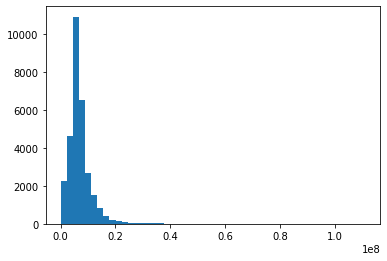

In [5]:
plt.figure(figsize=(6, 4))
plt.hist(train_df['price_doc'], bins=50);

## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

Overview

In [6]:
macro_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [7]:
macro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   timestamp                                   2484 non-null   datetime64[ns]
 1   oil_urals                                   2484 non-null   float64       
 2   gdp_quart                                   2394 non-null   float64       
 3   gdp_quart_growth                            2394 non-null   float64       
 4   cpi                                         2453 non-null   float64       
 5   ppi                                         2453 non-null   float64       
 6   gdp_deflator                                2119 non-null   float64       
 7   balance_trade                               2453 non-null   float64       
 8   balance_trade_growth                        2394 non-null   float64       
 9   usdrub 

So, we have some missing values and possible categorical features (object dtype)

In [8]:
for column in macro_df.select_dtypes('object').columns:
    print(f'{column}: {macro_df[column].unique()}')

child_on_acc_pre_school: ['45,713' '#!' '7,311' '3,013' '16,765' nan]
modern_education_share: [nan '90,92' '93,08' '95,4918']
old_education_build_share: [nan '23,14' '25,47' '8,2517']


Thus, it's just mistakes in the dataset, these features are not categorical. Let's correct them

In [9]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

Overview

In [10]:
train_df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [11]:
train_df.dtypes.unique()

array([dtype('<M8[ns]'), dtype('int64'), dtype('float64'), dtype('O')],
      dtype=object)

Again we have some missing values and possible categorical features (object dtype)

In [12]:
for column in train_df.select_dtypes('object').columns:
    unique_values = train_df[column].unique()
    if len(unique_values) > 5:
        print(f'{column}: {unique_values[:5]}, ...')
    else:
        print(f'{column}: {unique_values}')

product_type: ['Investment' 'OwnerOccupier']
sub_area: ['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Basmannoe'], ...
culture_objects_top_25: ['no' 'yes']
thermal_power_plant_raion: ['no' 'yes']
incineration_raion: ['no' 'yes']
oil_chemistry_raion: ['no' 'yes']
radiation_raion: ['no' 'yes']
railroad_terminal_raion: ['no' 'yes']
big_market_raion: ['no' 'yes']
nuclear_reactor_raion: ['no' 'yes']
detention_facility_raion: ['no' 'yes']
water_1line: ['no' 'yes']
big_road1_1line: ['no' 'yes']
railroad_1line: ['no' 'yes']
ecology: ['good' 'excellent' 'poor' 'satisfactory' 'no data']


Let's write function `encode()` to encode:
1. `timestamp` as 3 numbers: year, month, day
2. `product_type` as 0,1
3. `ecology` feature as 1, 2, 3, 4 
4. `yes/no` features as 0, 1

With the `sub_area` feature we will deal later

You can find function implementation in the `utils` folder, it is not placed here to get a more readable notebook. 

In [13]:
train_df = encode(train_df)
target = train_df.pop('price_doc')

### Test dataset

Overview

In [14]:
test_df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
id,,,,,,,,,,,,,,,,,,,,,
30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,...,8,0,0,0,1,10,1,0,14,1
30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,1.0,...,4,1,1,0,2,11,0,1,12,1
30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,...,42,11,4,0,10,21,0,10,71,11
30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,...,1,1,2,0,0,10,0,0,2,0
30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,1.0,...,5,1,1,0,2,12,0,1,11,1


Again we have some missing values and possible categorical features (object dtype)

In [15]:
test_df.dtypes.unique()

array([dtype('<M8[ns]'), dtype('float64'), dtype('int64'), dtype('O')],
      dtype=object)

In [16]:
for column in test_df.select_dtypes('object').columns:
    unique_values = test_df[column].unique()
    if len(unique_values) > 5:
        print(f'{column}: {unique_values[:5]}, ...')
    else:
        print(f'{column}: {unique_values}')

product_type: ['Investment' 'OwnerOccupier' nan]
sub_area: ['Juzhnoe Butovo' 'Poselenie Vnukovskoe' 'Perovo'
 'Poselenie Voskresenskoe' 'Filevskij Park'], ...
culture_objects_top_25: ['no' 'yes']
thermal_power_plant_raion: ['no' 'yes']
incineration_raion: ['no' 'yes']
oil_chemistry_raion: ['no' 'yes']
radiation_raion: ['no' 'yes']
railroad_terminal_raion: ['no' 'yes']
big_market_raion: ['no' 'yes']
nuclear_reactor_raion: ['no' 'yes']
detention_facility_raion: ['no' 'yes']
water_1line: ['no' 'yes']
big_road1_1line: ['no' 'yes']
railroad_1line: ['no' 'yes']
ecology: ['satisfactory' 'no data' 'poor' 'good' 'excellent']


As we can see, in the test dataset there are also some missing values in `product_type` feature compare to the train dataset

In [17]:
test_df.product_type.isna().sum()

33

To encode categorical features we can use our `encode()` function for the test dataset too

In [18]:
test_df = encode(test_df)

## II part (Filling missing values)

## 2. Encoding `sub_area` feature

take OKRUG + intersection with radius from KREMLIN

In [19]:
len(train_df['sub_area'].unique())

146

We have 146 different areas, one-hot encoding obviously is not the best approach for geo-data, so let's find their latitude and longitude

In [20]:
geo_df = pd.read_csv('data/geo_data.csv')
geo_df = geo_df.merge(gpd.read_file('data/mo.geojson'), on='NAME')
geo_df.drop(['OKATO', 'OKTMO', 'OKATO_AO', 'NAME_AO', 'ABBREV_AO'], axis=1, inplace=True)
geo_df = gpd.GeoDataFrame(geo_df)
geo_df.head()

,NAME,sub_area,OKRUG,TYPE_MO,geometry
0,Киевский,Poselenie Kievskij,Troitsky,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,Filevskij Park,Western,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,Poselenie Novofedorovskoe,Troitsky,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,Poselenie Rogovskoe,Troitsky,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",Poselenie Mosrentgen,Novomoskovsky,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


Now let's find the centroid of each polygon

In [21]:
geo_df['centre'] = geo_df['geometry'].to_crs(2263).centroid.to_crs(4326)
geo_df.head()

,NAME,sub_area,OKRUG,TYPE_MO,geometry,centre
0,Киевский,Poselenie Kievskij,Troitsky,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...",POINT (36.90054 55.38782)
1,Филёвский Парк,Filevskij Park,Western,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875...",POINT (37.48685 55.74925)
2,Новофёдоровское,Poselenie Novofedorovskoe,Troitsky,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551...",POINT (36.94725 55.44383)
3,Роговское,Poselenie Rogovskoe,Troitsky,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161...",POINT (37.06468 55.22055)
4,"""Мосрентген""",Poselenie Mosrentgen,Novomoskovsky,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042...",POINT (37.46581 55.61879)


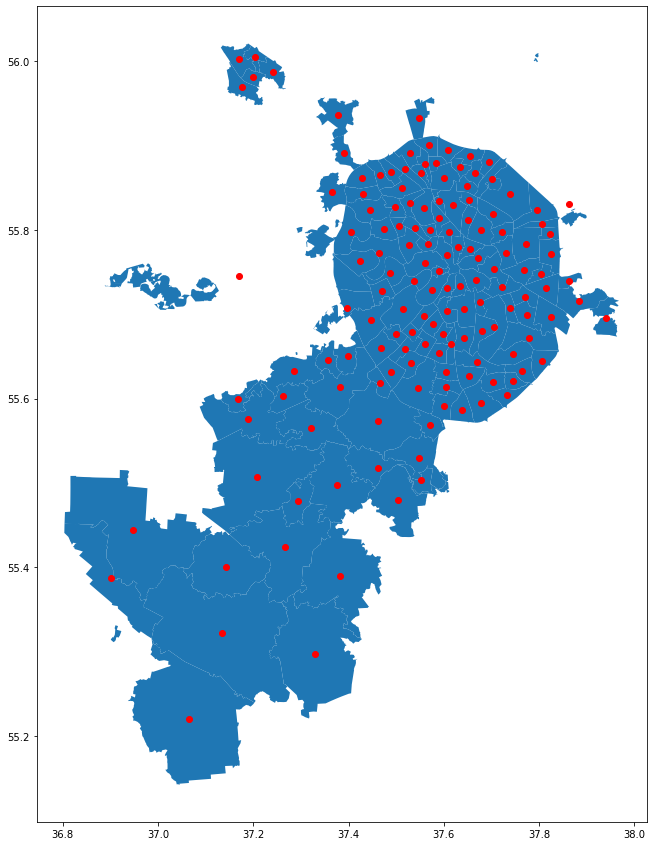

In [22]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1)
geo_df['geometry'].plot(ax=ax)
geo_df['centre'].plot(ax=ax, color='r');

Some centroids are shifted, let's analyze

In [23]:
def plotDot(row):
    folium.CircleMarker(location=(row['centre'].xy[1][0], row['centre'].xy[0][0]),
                        radius=3,
                        popup=row['NAME'],
                        color='red',
                        weight=5).add_to(m)

m = folium.Map(location = [55.4822200, 37.6156000], zoom_start=9)
geojson = folium.GeoJson(open('data/mo.geojson').read(), popup=folium.GeoJsonPopup(['NAME']))
geojson.add_to(m)
geo_df.apply(plotDot, axis=1)
m

"Кунцево", "Внуково", "Можайский" and etc. are complex regions, thus their's centroid are shifted, let's keep it in mind, we will solve it later

In [24]:
complex_regions_idx = [0, 10, 30, 139, 145]
geo_df.loc[complex_regions_idx]

,NAME,sub_area,OKRUG,TYPE_MO,geometry,centre
0,Киевский,Poselenie Kievskij,Troitsky,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...",POINT (36.90054 55.38782)
10,Внуково,Vnukovo,Western,Муниципальный округ,"MULTIPOLYGON (((37.23021 55.58532, 37.23537 55...",POINT (37.26331 55.60302)
30,Можайский,Mozhajskoe,Western,Муниципальный округ,"POLYGON ((37.32610 55.68286, 37.32909 55.68550...",POINT (37.39582 55.70807)
139,Восточный,Vostochnoe,Eastern,Муниципальный округ,"MULTIPOLYGON (((37.84533 55.81356, 37.85288 55...",POINT (37.86301 55.83104)
145,Кунцево,Kuncevo,Western,Муниципальный округ,"MULTIPOLYGON (((37.29050 55.80199, 37.29542 55...",POINT (37.17073 55.74568)


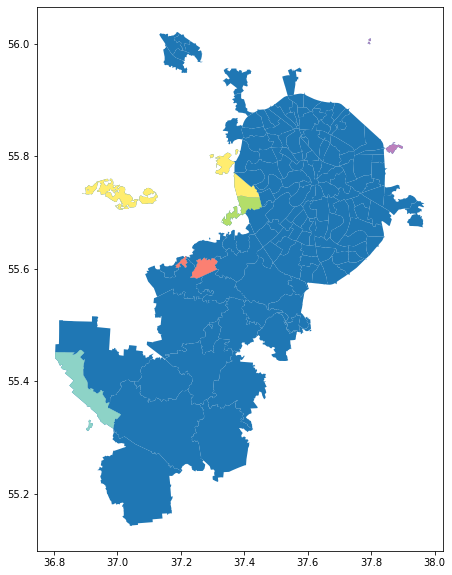

In [25]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
geo_df['geometry'].plot(ax=ax)
geo_df.loc[complex_regions_idx].plot(cmap='Set3', ax=ax);

In [26]:
# # Convert lat/lon (must be in radians) to Cartesian coordinates for each location.
# X = np.cos(lat) * np.cos(lon)
# Y = np.cos(lat) * np.sin(lon)
# Z = np.sin(lat)

# # Compute average x, y and z coordinates.
# x = np.mean(X)
# y = np.mean(Y)
# z = np.mean(Z)

# # Convert average x, y, z coordinate to latitude and longitude.
# Lon = np.atan2(y, x)
# Hyp = np.sqrt(x * x + y * y)
# Lat = np.atan2(z, hyp)

In [27]:
# # Get the shape-file for NYC
# boros = GeoDataFrame.from_file('./Borough Boundaries/geo_export_b641af01-6163-4293-8b3b-e17ca659ed08.shp')
# boros = boros.set_index('boro_code')
# boros = boros.sort_index()

# # Plot and color by borough
# boros.plot(column = 'boro_name')

# # Get rid of are that you aren't interested in (too far away)
# plt.gca().set_xlim([-74.05, -73.85])
# plt.gca().set_ylim([40.65, 40.9])

# # make a grid of latitude-longitude values
# xmin, xmax, ymin, ymax = -74.05, -73.85, 40.65, 40.9
# xx, yy = np.meshgrid(np.linspace(xmin,xmax,100), np.linspace(ymin,ymax,100))
# xc = xx.flatten()
# yc = yy.flatten()

# # Now convert these points to geo-data
# pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
# in_map =  np.array([pts.within(geom) for geom in boros.geometry]).sum(axis=0)
# pts = GeoSeries([val for pos,val in enumerate(pts) if in_map[pos]])

# # Plot to make sure it makes sense:
# pts.plot(markersize=1)

# # Now get the lat-long coordinates in a dataframe
# coords = []
# for n, point in enumerate(pts):
#     coords += [','.join(__ for __ in _.strip().split(' ')[::-1]) for _ in str(point).split('(')[1].split(')')[0].split(',')]


In [28]:
kremlin_ll = [55.752121, 37.617664]
train_df['kremlin_km']

id
1        15.156211
2         8.698054
3         9.067885
4        19.487005
5         2.578671
           ...    
30469    12.599292
30470     3.269284
30471    21.905792
30472    13.622569
30473    11.812614
Name: kremlin_km, Length: 30471, dtype: float64

In [29]:
# a = [-34.83333, -58.5166646]
# paris = [49.0083899664, 2.53844117956]
# bsas_in_radians = [radians(_) for _ in a]
# paris_in_radians = [radians(_) for _ in paris]
# result = haversine_distances([bsas_in_radians, paris_in_radians])
# result * 6371000/1000  # multiply by Earth radius to get kilometers

As a result, we can encode the `sub_area` feature as latitude and longitude 

In [30]:
geo_df['centre_latitude'] = geo_df['centre'].apply(lambda x: x.xy[1][0])
geo_df['centre_longitude'] = geo_df['centre'].apply(lambda x: x.xy[0][0])
geo_df.head()

,NAME,sub_area,OKRUG,TYPE_MO,geometry,centre,centre_latitude,centre_longitude
0,Киевский,Poselenie Kievskij,Troitsky,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55...",POINT (36.90054 55.38782),55.387819,36.900537
1,Филёвский Парк,Filevskij Park,Western,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875...",POINT (37.48685 55.74925),55.749250,37.486848
2,Новофёдоровское,Poselenie Novofedorovskoe,Troitsky,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551...",POINT (36.94725 55.44383),55.443828,36.947250
3,Роговское,Poselenie Rogovskoe,Troitsky,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161...",POINT (37.06468 55.22055),55.220553,37.064679
4,"""Мосрентген""",Poselenie Mosrentgen,Novomoskovsky,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042...",POINT (37.46581 55.61879),55.618791,37.465808


In [31]:
train_df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,timestamp_year,timestamp_month,timestamp_day
id,,,,,,,,,,,,,,,,,,,,,
1,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,13,22,1,0,52,4,2011,8,20
2,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,15,29,1,10,66,14,2011,8,23
3,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,11,27,0,4,67,10,2011,8,27
4,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,1,4,4,0,0,26,3,2011,9,1
5,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,17,135,236,2,91,195,14,2011,9,5


In [32]:
train_df = train_df.merge(geo_df[['sub_area', 'centre_latitude', 'centre_longitude']], on='sub_area', how='left')
test_df = test_df.merge(geo_df[['sub_area', 'centre_latitude', 'centre_longitude']], on='sub_area', how='left')

In [33]:
train_df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,timestamp_year,timestamp_month,timestamp_day,centre_latitude,centre_longitude
0,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,22,1,0,52,4,2011,8,20,55.894985,37.607986
1,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,29,1,10,66,14,2011,8,23,55.679674,37.680754
2,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,27,0,4,67,10,2011,8,27,55.707202,37.738192
3,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,4,0,0,26,3,2011,9,1,55.845368,37.365890
4,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,236,2,91,195,14,2011,9,5,55.766679,37.670843


## 3. Test dummy submits

Now let's just submit some dummy predictions from simple model without using macro dataset to check our initial score. In the competition, root mean squared logarithmic error is used as a scoring metric.

First of all, let's just use mean as a prediction for all inputs

In [37]:
X = train_df.drop(['sub_area'], axis=1).copy()
X_test = test_df.drop(['sub_area'], axis=1).copy()
y = target

In [38]:
class MeanRegressor():
    def fit(self, inputs, targets):
        self.mean = targets.mean()

    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

We will fill NaNs with means just to be able to use a simple model such as MeanRegressor

In [39]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X)

X[:] = imputer.transform(X)
X_test[:] = imputer.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((24376, 293), (24376,))

In [40]:
model = MeanRegressor()
model.fit(X, y)

In [41]:
create_submission(model, X_test)

In [42]:
# !kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "MeanRegressor"

Look just at the last submission

In [43]:
# !kaggle competitions submissions -c sberbank-russian-housing-market

PUBLIC: 0.52904, PRIVATE: 0.53355

Now let's try some more complex model

In [44]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=10, n_jobs=6)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_estimators=200,
                      n_jobs=6)

In [46]:
y_pred_train = np.abs(model.predict(X_train))
y_pred_val = np.abs(model.predict(X_val))
print('      TRAIN:', np.sqrt(mean_squared_log_error(y_train, y_pred_train)))
print('VALIDATION :', np.sqrt(mean_squared_log_error(y_val, y_pred_val)))

      TRAIN: 0.44724604674605734
VALIDATION : 0.47301445126403385


In [48]:
create_submission(model, X_test)

In [49]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=10)"

100%|████████████████████████████████████████| 180k/180k [00:02<00:00, 69.4kB/s]
Successfully submitted to Sberbank Russian Housing Market

Look just at the last submission

In [51]:
# !kaggle competitions submissions -c sberbank-russian-housing-market

PUBLIC: 0.32885, PRIVATE: 0.32756

Let's try SOTA model XGBRegressor with naive initialization

In [55]:
params = {'n_estimators': 200,
          'booster': 'gbtree',
          'max_depth': 5,
          'eval_metric': 'mae',
          'learning_rate': 0.2,
          # 'reg_alpha': 100,
          'min_child_weight': 0,
          # 'subsample': 0.8,
          # 'colsample_bytree': 0.79,
          'seed': 42,
          'nthread': -1
          }

model = XGBRegressor(objective='reg:squarederror', **params)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])


[0]	validation_0-mae:5749353.50000	validation_1-mae:5654003.50000
[1]	validation_0-mae:4728213.50000	validation_1-mae:4646302.00000
[2]	validation_0-mae:3959958.25000	validation_1-mae:3896507.00000
[3]	validation_0-mae:3371958.00000	validation_1-mae:3317466.00000
[4]	validation_0-mae:2914744.00000	validation_1-mae:2872221.50000
[5]	validation_0-mae:2559883.50000	validation_1-mae:2536318.75000
[6]	validation_0-mae:2289945.75000	validation_1-mae:2276337.75000
[7]	validation_0-mae:2081874.12500	validation_1-mae:2082050.00000
[8]	validation_0-mae:1922175.50000	validation_1-mae:1927987.87500
[9]	validation_0-mae:1803073.00000	validation_1-mae:1813708.12500
[10]	validation_0-mae:1708804.62500	validation_1-mae:1725958.25000
[11]	validation_0-mae:1637652.62500	validation_1-mae:1659950.75000
[12]	validation_0-mae:1586155.87500	validation_1-mae:1612119.75000
[13]	validation_0-mae:1543110.37500	validation_1-mae:1571585.75000
[14]	validation_0-mae:1507161.00000	validation_1-mae:1537504.00000
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [56]:
y_pred_train = np.abs(model.predict(X_train))
y_pred_val = np.abs(model.predict(X_val))
print('      TRAIN:', np.sqrt(mean_squared_log_error(y_train, y_pred_train)))
print('VALIDATION :', np.sqrt(mean_squared_log_error(y_val, y_pred_val)))

      TRAIN: 0.3882872192689894
VALIDATION : 0.4656559689186529


In [57]:
create_submission(model, X_test)

In [58]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "XGBRegressor"

100%|████████████████████████████████████████| 121k/121k [00:02<00:00, 57.9kB/s]
Successfully submitted to Sberbank Russian Housing Market

Look just at the last submission

In [60]:
# !kaggle competitions submissions -c sberbank-russian-housing-market

In [62]:
params = {'n_estimators': 400,
          'booster': 'gbtree',
          'max_depth': 5,
          'eval_metric': 'mae',
          'learning_rate': 0.2,
          # 'reg_alpha': 100,
          'min_child_weight': 0,
          # 'subsample': 0.8,
          # 'colsample_bytree': 0.79,
          'seed': 42,
          'nthread': -1
          }

model = XGBRegressor(objective='reg:squarederror', **params)
model.fit(X, y, eval_set=[(X, y)])


[0]	validation_0-mae:5730035.50000
[1]	validation_0-mae:4711527.50000
[2]	validation_0-mae:3947046.25000
[3]	validation_0-mae:3359509.75000
[4]	validation_0-mae:2906396.25000
[5]	validation_0-mae:2555400.50000
[6]	validation_0-mae:2284893.00000
[7]	validation_0-mae:2075644.12500
[8]	validation_0-mae:1917182.50000
[9]	validation_0-mae:1797304.12500
[10]	validation_0-mae:1703203.50000
[11]	validation_0-mae:1633175.37500
[12]	validation_0-mae:1578226.87500
[13]	validation_0-mae:1536859.12500
[14]	validation_0-mae:1501700.75000
[15]	validation_0-mae:1472179.12500
[16]	validation_0-mae:1449741.00000
[17]	validation_0-mae:1433344.50000
[18]	validation_0-mae:1421243.00000
[19]	validation_0-mae:1405869.12500
[20]	validation_0-mae:1393816.12500
[21]	validation_0-mae:1382826.00000
[22]	validation_0-mae:1373780.12500
[23]	validation_0-mae:1364751.37500
[24]	validation_0-mae:1356306.75000
[25]	validation_0-mae:1350363.50000
[26]	validation_0-mae:1343058.37500
[27]	validation_0-mae:1337840.50000
[2

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [63]:
create_submission(model, X_test)

In [64]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "XGBRegressor"

100%|████████████████████████████████████████| 121k/121k [00:01<00:00, 68.0kB/s]
Successfully submitted to Sberbank Russian Housing Market

Look just at the last submission

In [ ]:
# !kaggle competitions submissions -c sberbank-russian-housing-market

In [ ]:
my_score = 0.32494
get_place(my_score)

1936 / 3266


As we can see there is a quite big difference between leaderboard score and local validation. Moreover, they are worse than test one, this is strange. Let's try the cross-validation approach

In [ ]:
model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=30)

scores = cross_val_score(model,
                         X, y,
                         cv=KFold(n_splits=5, shuffle=True, random_state=42),
                         scoring='neg_mean_squared_log_error',
                         n_jobs=6)
print(scores)
print('MEAN:', np.mean(np.abs(scores)))

[-0.40210606 -0.39040884 -0.4035048  -0.40084658 -0.4065605 ]
MEAN: 0.4006853570069812


In [ ]:
# !!!for n_split in n_splits:!!!



# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf_splits = list(kf.split(X))

# plt.figure(figsize=(12, 10))
# for i in range(5):
#     plt.subplot(3, 2, i + 1)
#     plt.hist(y.values[kf_splits[i][0]], bins=20, label=f'Train_{i + 1}')
#     plt.hist(y.values[kf_splits[i][1]], bins=20, label=f'Test_{i + 1}')
#     plt.legend();

Now scores are less than that on the leaderboard which is more logical but anyway they are quite different. 















# Let's continue our analysis

In [ ]:
# idx_2011 = train_df[train_df['timestamp_year'] == 2011].index
# idx_2012 = train_df[train_df['timestamp_year'] == 2012].index
# idx_2013 = train_df[train_df['timestamp_year'] == 2013].index
# idx_2014 = train_df[train_df['timestamp_year'] == 2014].index
# idx_2015 = train_df[train_df['timestamp_year'] == 2015].index

In [ ]:
# plt.figure(figsize=(15, 8))

# plt.subplot(2, 3, 1)
# plt.hist(y[idx_2011], bins=15, density=True, label='2011')
# plt.legend();

# plt.subplot(2, 3, 2)
# plt.hist(y[idx_2012], bins=15, density=True, label='2012')
# plt.legend();

# plt.subplot(2, 3, 3)
# plt.hist(y[idx_2013], bins=15, density=True, label='2013')
# plt.legend();

# plt.subplot(2, 3, 4)
# plt.hist(y[idx_2014], bins=15, density=True, label='2014')
# plt.legend();

# plt.subplot(2, 3, 5)
# plt.hist(y[idx_2015], bins=15, density=True, label='2015')
# plt.legend();

In [ ]:
fix_df = pd.read_excel('data/BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')
name2sub_area = pd.read_csv('data/name2sub_area.csv', index_col='sub_area')
# train_df.update(fix_df, overwrite=True)
# test_df.update(fix_df, overwrite=True)
del fix_df

In [ ]:
train_macro_df = train_df.merge(macro_df, on='timestamp', how='left')
test_macro_df = test_df.merge(macro_df, on='timestamp', how='left' )

In [ ]:
train_macro_df['sub_area'] = train_macro_df['sub_area'].map(name2sub_area['OKRUG'].to_dict())
test_macro_df['sub_area'] = test_macro_df['sub_area'].map(name2sub_area['OKRUG'].to_dict())
del name2sub_area

In [ ]:
model = XGBRegressor(objective='reg:squarederror', **params)
cross_val_score(model, X, y, cv=KFold(shuffle=True, random_state=42), scoring='neg_mean_squared_log_error', n_jobs=6)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   36.3s finished


array([-0.22770237, -0.22812722, -0.22101153, -0.23741211, -0.2331106 ])

In [ ]:
cv_results = [-0.22770237, -0.22812722, -0.22101153, -0.23741211, -0.2331106]
np.mean(np.abs(cv_results))

0.229472766

### train_test_split 
```
local = {'train':0.46444, 
         'test': 0.47718}
```
real: (0.33844, 0.33819)
### naive cv
local: 0.23
real: (0.32886, 0.32857)
### smart cv
local: (0.44323, 0.46569)
real: (0.32886, 0.32857)

In [ ]:
def create_submission(model):
    submission = pd.read_csv('data/sample_submission.csv')
    pred = model.predict(X_test)
    if len(pred[pred < 0]):
        print('WARNING: NEGATIVE PREDICTIONS')
        pred = np.abs(pred)
    submission['price_doc'] = pred
    submission.to_csv('submission.csv', index=False)

In [ ]:
create_submission(model)

In [ ]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "test train_test_split"

100%|████████████████████████████████████████| 121k/121k [00:02<00:00, 60.6kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [ ]:
!kaggle competitions submissions -c sberbank-russian-housing-market

fileName        date                 description                                   status    publicScore  privateScore  
--------------  -------------------  --------------------------------------------  --------  -----------  ------------  
submission.csv  2021-11-19 19:43:05  test train_test_split                         complete  0.33844      0.33819       
submission.csv  2021-11-19 19:11:49  test train_test_split                         complete  0.32886      0.32857       
submission.csv  2021-11-19 19:10:42  test train_test_split                         complete  0.32886      0.32857       
submission.csv  2021-11-12 18:19:49  naive XGBRegressor with OKRUG                 complete  0.33627      0.34593       
submission.csv  2021-11-12 18:07:03  naive XGBRegressor with OKRUG                 complete  0.33615      0.35028       
submission.csv  2021-11-12 18:02:19  naive XGBRegressor with OKRUG                 complete  0.32857      0.33310       
submission.csv  2021-11-12 17:31

In [ ]:
def get_place(my_score):
    df = pd.read_csv('publicleaderboard.csv')
    scores = df['Score'].values
    scores = np.append(scores, my_score)
    scores = np.sort(scores)
    print(f'{np.where(scores == my_score)[0][0]} / {len(scores)}')

In [ ]:
my_score = 0.32494
get_place(my_score)

1936 / 3266
